#  Model Fine-Tuning – Emotion Classification with BERT (Persian)

This notebook focuses on **fine-tuning a pre-trained BERT model** for Persian emotion classification using the cleaned and labeled tweet dataset.

Below is the high-level pipeline we follow:

---

## 🔁 Step-by-Step Overview

### 📂 1. Load Preprocessed Dataset
We load the previously saved Hugging Face `DatasetDict`, which contains:
- Training set
- Validation set
- Test set (ArmanEmo)

---

### ✂️ 2. Tokenization  
We tokenize the text using the **Persian BERT tokenizer** from:

**`HooshvareLab/bert-base-parsbert-uncased`**

This tokenizer is specifically trained for Persian and supports:
- Proper handling of Persian spacing and morphology
- Efficient input formatting for BERT

---

### ⚖️ 3. Compute Class Weights
Due to class imbalance, we calculate **class weights** and apply them to the loss function. This helps the model not to overfit on majority classes.

---



## 🛠 4. Custom Trainer with Weighted Loss & Metric Computation

To address **class imbalance**, we define a custom `Trainer` by overriding the `compute_loss()` method and applying **weighted cross-entropy loss** using precomputed class weights. This ensures that underrepresented emotion classes contribute more to the loss, improving model fairness.

We define a `compute_metrics` function to track:
- Accuracy
- F1-score
- Precision & Recall (macro)

---

### 🚀 5. Model Training
We initialize the `Trainer`, set hyperparameters, and fine-tune the model on the training set while validating on the validation set.

---

### 📈 6. Evaluation
After training:
- Evaluate performance on the test set (ArmanEmo)
- Visualize results with a **confusion matrix**

---

### 🧪 7. Custom Predictions and Saving the Model
We manually test the model by feeding it sample texts and observing the predicted emotion labels.

Save the fine-tuned model and tokenizer locally or push to Hugging Face Hub for reuse.

---

Each of these steps is detailed and implemented in the following sections.


## 📂 1. Load Preprocessed Dataset   
We load the **already cleaned and preprocessed** dataset saved in Hugging Face's `DatasetDict` format. It includes:

- **Training set** (`train`)
- **Validation set** (`val`)
- **Test set** (`test` – from ArmanEmo)

This step assumes all necessary text cleaning, label encoding, and formatting were completed beforehand. The dataset is ready for tokenization and training.


In [1]:
# at first we install transfomer for avoid restart the notebook in the progress
%pip install git+https://github.com/huggingface/transformers.git --no-deps --upgrade
%pip install --upgrade numpy
%pip install transformers -U

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-12344ymb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-12344ymb
  Resolved https://github.com/huggingface/transformers.git to commit 4abb053b6c7ea894c2e85eb9fabb0a3258e87c55
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.55.0.dev0-py3-none-any.whl size=12117010 sha256=c2df931c39138a3f67794e74f94810dee1ebc9a626fe936fe39635f2d1eb8334
  Stored in directory: /tmp/pip-ephem-wheel-cache-_a5zh9n4/wheels/32/4b/78/f195c684dd3a9ed21f3b39fe8f85b48df7918581b6437be143
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0
     ━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# conect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from datasets import load_from_disk
import numpy as np

dataset = load_from_disk("/content/drive/My Drive/Bert/Data/Processed/DatasetDict")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__'],
        num_rows: 7600
    })
    val: Dataset({
        features: ['text', 'label_name', 'label'],
        num_rows: 845
    })
    test: Dataset({
        features: ['text', 'label_name', 'label'],
        num_rows: 958
    })
})

## ✂️ 2. Tokenization

We use the **HooshvareLab/bert-base-parsbert-uncased** tokenizer to tokenize our dataset. This step converts raw Persian text into token IDs that can be processed by the model.

Key steps in this stage:

- Load the tokenizer using `AutoTokenizer` from HuggingFace Transformers.
- Build `label2id` and `id2label` dictionaries for mapping string labels to integers and vice versa.
- Define a `tokenize` function that applies padding and truncation to each text example.
- Use the `.map()` function with `batched=True` to apply the tokenizer across the entire dataset efficiently.

✅ The result is an `encoded_dataset` where each example contains the tokenized input ready for training.


In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [6]:
tokenizer.vocab_size

100000

In [7]:
unique_labels = dataset["train"].unique("label_name")
label2id = {label: idx for idx, label in enumerate(sorted(unique_labels))}
id2label = {idx: label for label, idx in label2id.items()}

In [8]:
label2id ,id2label

({'ANGRY': 0, 'FEAR': 1, 'HAPPY': 2, 'HATE': 3, 'SAD': 4, 'SURPRISE': 5},
 {0: 'ANGRY', 1: 'FEAR', 2: 'HAPPY', 3: 'HATE', 4: 'SAD', 5: 'SURPRISE'})

In [10]:
def tokenize(batch):
  temp = tokenizer(batch['text'] ,padding = True , truncation=True )
  return temp

In [9]:
dataset['train'][0]

{'text': 'چقدر ما دهه ایها عجیب و غریب و زودبزرگشدبم با کولهباری تجربه',
 'label_name': 'SURPRISE',
 'label': 5,
 '__index_level_0__': 7820}

In [11]:
tokenize(dataset['train'][0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [2, 5243, 2179, 3985, 18404, 5644, 331, 10411, 331, 4804, 12233, 2139, 56965, 2037, 68204, 3482, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
encoded_dataset = dataset.map(tokenize , batched=True )

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/845 [00:00<?, ? examples/s]

Map:   0%|          | 0/958 [00:00<?, ? examples/s]

In [14]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
    val: Dataset({
        features: ['text', 'label_name', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 845
    })
    test: Dataset({
        features: ['text', 'label_name', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 958
    })
})

📦 Load Pretrained Model

We load the **pretrained BERT model** from `HooshvareLab/bert-base-parsbert-uncased` and adapt it for **sequence classification** with 6 emotion classes.
To ensure the model understands our label mapping, we explicitly define `id2label` and `label2id` dictionaries, and set `num_labels=6`.
This step transforms the base BERT encoder into a classification model suitable for **emotion detection** in Persian text.



In [15]:
from transformers import AutoModelForSequenceClassification

In [16]:
model_name = "HooshvareLab/bert-base-parsbert-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    id2label = id2label ,
    label2id =label2id ,
    num_labels=6 ,
)


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [18]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "ANGRY",
    "1": "FEAR",
    "2": "HAPPY",
    "3": "HATE",
    "4": "SAD",
    "5": "SURPRISE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ANGRY": 0,
    "FEAR": 1,
    "HAPPY": 2,
    "HATE": 3,
    "SAD": 4,
    "SURPRISE": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.55.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

## ⚖️ 3. Compute Class Weights

Our dataset is **imbalanced**, meaning some emotion classes appear more frequently than others. To address this, we compute **class weights** to penalize misclassification of minority classes more during training.

Steps:

- Use `Counter` to count occurrences of each label in the training set.
- Use `sklearn.utils.class_weight.compute_class_weight` to calculate weights inversely proportional to class frequencies.
- Convert the result to a PyTorch tensor so it can be directly passed to the loss function (e.g., `CrossEntropyLoss(weight=class_weights)`).

📌 This helps the model give **equal importance** to all classes regardless of their frequency.


In [28]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Count label occurrences
label_list = dataset["train"]["label"]
label_counts = dict(sorted(Counter(label_list).items()))
counts = np.array(list(label_counts.values()))

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(6),
    y=np.array(label_list)
)

# Convert to tensor
class_weights = torch.tensor(weights, dtype=torch.float)


In [29]:
class_weights

tensor([0.7029, 1.2654, 0.6570, 2.4984, 0.7626, 1.8069])



## 🛠 4. Custom Trainer with Weighted Loss & Metric Computation

To address **class imbalance**, we define a custom `Trainer` by overriding the `compute_loss()` method and applying **weighted cross-entropy loss** using precomputed class weights. This ensures that underrepresented emotion classes contribute more to the loss, improving model fairness.


In [36]:
from transformers import Trainer
import torch.nn as nn
import torch

# Define a custom Trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False ,num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Apply weighted loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss



We also implement `compute_metrics()` to evaluate the model with **accuracy**, **F1**, **precision**, and **recall** scores (all using macro averaging for balanced evaluation across classes).



In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    return {
        "accuracy": (preds == labels).mean(),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro")
    }



##🚀 5. Model Training

In this section, we define the training configuration using Hugging Face’s `TrainingArguments` and train our model using the custom `WeightedTrainer`.

Key highlights:

* **`TrainingArguments`** defines hyperparameters and training settings, such as:

  * `learning_rate=1e-5`, `num_train_epochs=6` – tailored for fine-tuning on our emotion dataset.
  * Evaluation and model saving happen **at each epoch** (`eval_strategy="epoch"`).
  * **Logging** every 50 steps to monitor training progress.
  * **Class imbalance** is addressed by applying class weights in the `WeightedTrainer`.
  * The **best model** (based on evaluation loss) is automatically loaded at the end.

* **`WeightedTrainer`** overrides the `compute_loss` method to apply **weighted cross-entropy**, helping the model learn from underrepresented classes more effectively.

* Finally, simplicity and call `trainer.train()` to begin the training loop.

This setup ensures robust training while accounting for imbalanced data and providing useful evaluation metrics like accuracy, precision, recall, and F1-score.


In [38]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="./results",

    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    learning_rate = 1e-5 ,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,

    weight_decay =0.01,
    logging_dir="./logs",
    disable_tqdm=False,

    save_steps=500,
    report_to="none",
    load_best_model_at_end =True
)



In [39]:
from torch.nn import CrossEntropyLoss
device ='cuda'
loss_fn = CrossEntropyLoss(weight=class_weights.to(device))  # Add class weights for imbalance handling

In [40]:
from transformers import EarlyStoppingCallback
# Initialize custom trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],

)


/tmp/ipython-input-40-247094166.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [41]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.019700,0.885937,0.649704,0.656711,0.651421,0.696249
2,0.715400,0.758173,0.701775,0.709831,0.691241,0.742911
3,0.549300,0.752275,0.712426,0.719661,0.708655,0.747446
4,0.459400,0.758669,0.723077,0.732249,0.725643,0.745850
5,0.356200,0.762511,0.723077,0.734038,0.726450,0.750044


TrainOutput(global_step=1190, training_loss=0.6872211536439528, metrics={'train_runtime': 870.0923, 'train_samples_per_second': 52.408, 'train_steps_per_second': 1.641, 'total_flos': 1756493820069120.0, 'train_loss': 0.6872211536439528, 'epoch': 5.0})


## 📈 6. Evaluation

After training the model, we evaluate its performance using a held-out **test set**, in this case the `Arman Emotion Test Set`, which contains labeled examples of emotional text in Persian.

We first run Hugging Face's built-in `trainer.evaluate()` method to compute general metrics such as **loss and accuracy** over the test set.


In [42]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.7522749900817871, 'eval_accuracy': 0.7124260355029586, 'eval_f1': 0.7196605234050706, 'eval_precision': 0.7086550577352947, 'eval_recall': 0.7474461475740374, 'eval_runtime': 5.1451, 'eval_samples_per_second': 164.232, 'eval_steps_per_second': 5.248, 'epoch': 5.0}




Then, we use `trainer.predict()` to get the model's raw output logits and true labels for the test set. These are converted to predicted class labels using `argmax`.


In [56]:
pred_output = trainer.predict(encoded_dataset['test'])
pred_output.metrics

{'test_loss': 0.9895099401473999,
 'test_accuracy': 0.708768267223382,
 'test_f1': 0.6634753417303749,
 'test_precision': 0.6625207744579852,
 'test_recall': 0.6716741949242193,
 'test_runtime': 3.7689,
 'test_samples_per_second': 254.186,
 'test_steps_per_second': 7.96}

In [57]:
# Get class names from model config or dataset
class_names = list(model.config.id2label.values())  # or custom list

In [58]:
# Get predictions and labels from trainer output
predictions = np.argmax(pred_output.predictions, axis=-1)
labels = pred_output.label_ids


To assess performance in more detail, we compute a **classification report** using scikit-learn, which includes:

* **Precision**
* **Recall**
* **F1-Score**
* **Support** (number of samples per class)


In [59]:
from sklearn.metrics import classification_report
report = classification_report(labels, predictions, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

       ANGRY     0.6014    0.5779    0.5894       154
        FEAR     0.6267    0.8246    0.7121        57
       HAPPY     0.8566    0.8036    0.8293       275
        HATE     0.5185    0.4308    0.4706        65
         SAD     0.7103    0.7863    0.7464       262
    SURPRISE     0.6617    0.6069    0.6331       145

    accuracy                         0.7088       958
   macro avg     0.6625    0.6717    0.6635       958
weighted avg     0.7094    0.7088    0.7070       958




Finally, we compute and visualize a **normalized confusion matrix**, which shows how often each class is correctly or incorrectly predicted relative to its true label. This helps identify where the model is confusing similar emotional categories.

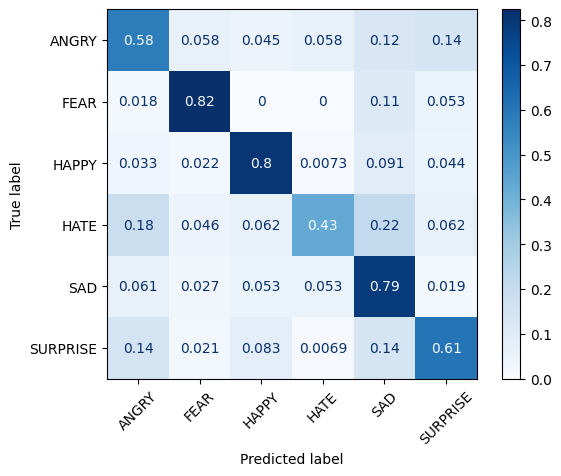

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_normalized = confusion_matrix(labels, predictions, normalize='true')

class_names = list(model.config.id2label.values())

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)



## 🧪 7. Custom Predictions and Saving the Model

In this section, a custom `predict` function is defined to classify the emotion of Persian text using a fine-tuned BERT model.

* The input text is first tokenized using the `tokenizer` and moved to the appropriate device (GPU if available, otherwise CPU).
* Inference is performed under `torch.no_grad()` to disable gradient calculations, making prediction faster and memory-efficient.
* The model’s output logits are used to determine the predicted class by selecting the index with the highest score.
* This class index is then mapped to a human-readable label using the model's `id2label` configuration.


In [48]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict(text):
    # Tokenize input text and move to device
    encoded_input = tokenizer(text, return_tensors="pt").to(device)

    # Inference
    with torch.no_grad():
        outputs = model(**encoded_input)

    # Get predicted class index
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()

    # Get label name from id2label mapping
    label = model.config.id2label[predicted_class_id]

    return label


A list of Persian sentences expressing different emotions is then used to test the prediction function. Each sentence is passed through the `predict` function, and its corresponding predicted emotion is printed.


In [49]:
persian_samples = [
    "چه هوای زیبایی امروز است",
    "از این فیلم خیلی خوشم آمد",
    "دیروز خیلی خسته بودم",
    "من از این غذا اصلا راضی نیستم",
    "امیدوارم فردا روز بهتری باشد",
    "این محصول کیفیت خوبی ندارد",
    "دوست دارم به مسافرت بروم",
    "این کتاب خیلی آموزنده است",
    "احساس می‌کنم امروز حال خوبی دارم",
    "این پروژه برای من چالش بزرگی بود"
]

In [52]:
for sample in persian_samples :
 print(sample + "   : " +predict(sample))

چه هوای زیبایی امروز است   : HAPPY
از این فیلم خیلی خوشم آمد   : HAPPY
دیروز خیلی خسته بودم   : SAD
من از این غذا اصلا راضی نیستم   : ANGRY
امیدوارم فردا روز بهتری باشد   : HAPPY
این محصول کیفیت خوبی ندارد   : ANGRY
دوست دارم به مسافرت بروم   : HAPPY
این کتاب خیلی آموزنده است   : HAPPY
احساس می‌کنم امروز حال خوبی دارم   : HAPPY
این پروژه برای من چالش بزرگی بود   : SAD



Finally, the trained model (and tokenizer) .


In [53]:
trainer.save_model("Persian-Emotion-Classification-BERT")